#### Week 4 Challenge
##### Rossmann Pharmaceuticals 
##### Predicting Store Sales

In [4]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

script_dir = r'E:\2017.Study\Tenx\Week-4\Rossmann\Week.4\W4.Rossman\scripts'
src_dir = r'E:\2017.Study\Tenx\Week-4\Rossmann\Week.4\W4.Rossman\src'

data_dir = r'E:\2017.Study\Tenx\Week-4\Data\data'
sys.path.append(script_dir)
sys.path.append(src_dir)
sys.path.append(data_dir)
from Data_Preprocessing import DataProcessor
from Data_Preprocessing import CustomerBehaviorAnalyzer
from ML_processing import RossmannModel

In [5]:
data_dir = r'E:\2017.Study\Tenx\Week-4\Data\data'
    # Initialize DataProcessor and load data
processor = DataProcessor(data_dir)
processor.load_data()
missing_values = processor.check_missing_values()
print("\nMissing Values:")
display(missing_values)


Missing Values:


{'train': Store            0
 DayOfWeek        0
 Date             0
 Sales            0
 Customers        0
 Open             0
 Promo            0
 StateHoliday     0
 SchoolHoliday    0
 dtype: int64,
 'test': Id                0
 Store             0
 DayOfWeek         0
 Date              0
 Open             11
 Promo             0
 StateHoliday      0
 SchoolHoliday     0
 dtype: int64,
 'store': Store                          0
 StoreType                      0
 Assortment                     0
 CompetitionDistance            3
 CompetitionOpenSinceMonth    354
 CompetitionOpenSinceYear     354
 Promo2                         0
 Promo2SinceWeek              544
 Promo2SinceYear              544
 PromoInterval                544
 dtype: int64}

In [6]:
processor.handle_missing_values()
missing_values_after = processor.check_missing_values()
print("\nMissing Values After Handling:")
display(missing_values_after)


Missing Values After Handling:


{'train': Store            0
 DayOfWeek        0
 Date             0
 Sales            0
 Customers        0
 Open             0
 Promo            0
 StateHoliday     0
 SchoolHoliday    0
 dtype: int64,
 'test': Id               0
 Store            0
 DayOfWeek        0
 Date             0
 Open             0
 Promo            0
 StateHoliday     0
 SchoolHoliday    0
 dtype: int64,
 'store': Store                        0
 StoreType                    0
 Assortment                   0
 CompetitionDistance          0
 CompetitionOpenSinceMonth    0
 CompetitionOpenSinceYear     0
 Promo2                       0
 Promo2SinceWeek              0
 Promo2SinceYear              0
 PromoInterval                0
 dtype: int64}

#### Preprocessing.ML

Data preprocessing is a crucial step in machine learning because it directly impacts the quality and accuracy of the model's predictions.
By cleaning, transforming, and preparing the data, we ensure that the model can effectively learn from the information provided. This involves tasks like handling missing values, converting data types, normalizing features, and creating new features. Without proper preprocessing, models may struggle to learn meaningful patterns, leading to biased or inaccurate results.

#### Analyzing Future selection using Correlation 

Correlation with Sales:
Sales            1.000000
Customers        0.894711
Open             0.678472
Promo            0.452345
SchoolHoliday    0.085124
Store            0.005126
DayOfWeek       -0.462125
Name: Sales, dtype: float64


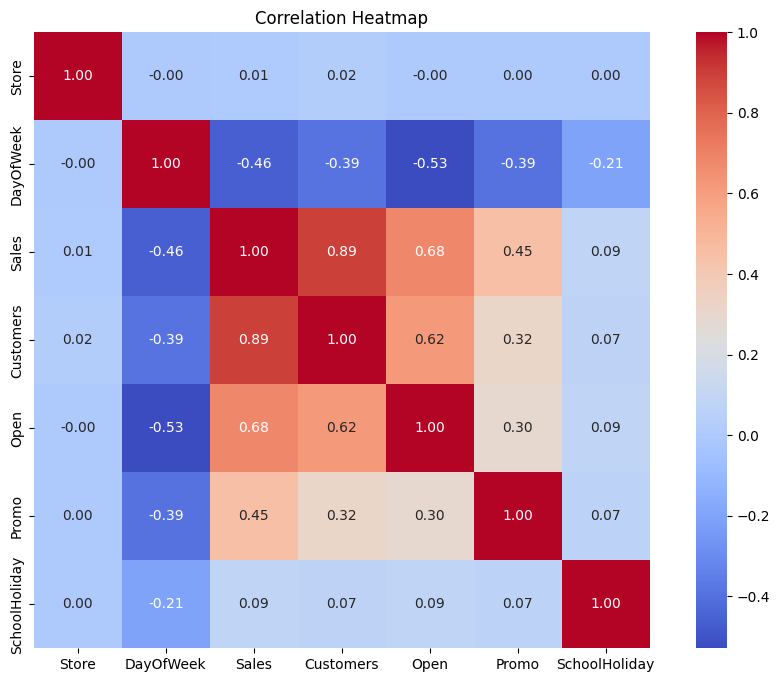

Selected Features based on correlation threshold 0.1: ['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo']


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert date columns (if any) to datetime type, exclude from correlation
if 'Date' in processor.train_df.columns:
    processor.train_df['Date'] = pd.to_datetime(processor.train_df['Date'])

# Select only numeric columns for correlation
numeric_df = processor.train_df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

print("Correlation with Sales:")
print(correlation_matrix['Sales'].sort_values(ascending=False))

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Select features based on a correlation threshold
threshold = 0.1
correlated_features = correlation_matrix.index[abs(correlation_matrix['Sales']) > threshold].tolist()
print(f"Selected Features based on correlation threshold {threshold}: {correlated_features}")



In [8]:
# Convert 'Date' column in train and test datasets to datetime
processor.train_df['Date'] = pd.to_datetime(processor.train_df['Date'])
processor.test_df['Date'] = pd.to_datetime(processor.test_df['Date'])

# Merge store data into train and test sets on 'Store' column
train_df = pd.merge(processor.train_df, processor.store_df, how='left', on='Store')
test_df = pd.merge(processor.test_df, processor.store_df, how='left', on='Store')

# Extract additional features from the 'Date' column
def extract_date_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 6 else 0)
    df['IsBeginningOfMonth'] = df['Day'].apply(lambda x: 1 if x <= 10 else 0)
    df['IsMidMonth'] = df['Day'].apply(lambda x: 1 if 11 <= x <= 20 else 0)
    df['IsEndOfMonth'] = df['Day'].apply(lambda x: 1 if x > 20 else 0)

# Apply the function to both train and test datasets
extract_date_features(train_df)
extract_date_features(test_df)

# Check the first few rows of the updated train dataset
train_df.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0.0,None,2015,7,31,31,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0.0,None,2015,7,31,31,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0.0,None,2015,7,31,31,0,0,0,1


In [7]:
# Handle missing values by creating a new column or modifying the original safely
train_df = train_df.copy()
test_df = test_df.copy()

# Fill missing competition and promotion-related values
train_df['CompetitionDistance'] = train_df['CompetitionDistance'].fillna(train_df['CompetitionDistance'].median())
train_df['CompetitionOpenSinceMonth'] = train_df['CompetitionOpenSinceMonth'].fillna(0)
train_df['CompetitionOpenSinceYear'] = train_df['CompetitionOpenSinceYear'].fillna(0)
train_df['Promo2SinceWeek'] = train_df['Promo2SinceWeek'].fillna(0)
train_df['Promo2SinceYear'] = train_df['Promo2SinceYear'].fillna(0)
train_df['PromoInterval'] = train_df['PromoInterval'].fillna('None')

test_df['CompetitionDistance'] = test_df['CompetitionDistance'].fillna(test_df['CompetitionDistance'].median())
test_df['CompetitionOpenSinceMonth'] = test_df['CompetitionOpenSinceMonth'].fillna(0)
test_df['CompetitionOpenSinceYear'] = test_df['CompetitionOpenSinceYear'].fillna(0)
test_df['Promo2SinceWeek'] = test_df['Promo2SinceWeek'].fillna(0)
test_df['Promo2SinceYear'] = test_df['Promo2SinceYear'].fillna(0)
test_df['PromoInterval'] = test_df['PromoInterval'].fillna('None')

# Convert categorical columns to numeric (one-hot encoding)
train_encoded = pd.get_dummies(train_df, columns=['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'], drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'], drop_first=True)

# Check the processed train dataset after encoding
train_encoded.head()



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_c,StoreType_d,Assortment_b,Assortment_c,StateHoliday_a,StateHoliday_b,StateHoliday_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
0,1,5,2015-07-31,5263,555,1,1,1,1270.0,9.0,...,True,False,False,False,False,False,False,False,False,True
1,2,5,2015-07-31,6064,625,1,1,1,570.0,11.0,...,False,False,False,False,False,False,False,True,False,False
2,3,5,2015-07-31,8314,821,1,1,1,14130.0,12.0,...,False,False,False,False,False,False,False,True,False,False
3,4,5,2015-07-31,13995,1498,1,1,1,620.0,9.0,...,True,False,False,True,False,False,False,False,False,True
4,5,5,2015-07-31,4822,559,1,1,1,29910.0,4.0,...,False,False,False,False,False,False,False,False,False,True


In [9]:
# Convert categorical variables to numeric (using one-hot encoding)
import pandas as pd
from sklearn.preprocessing import StandardScaler
train_encoded = pd.get_dummies(train_df, columns=['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'], drop_first=True)
test_encoded = pd.get_dummies(train_df, columns=['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'], drop_first=True)

# Feature Scaling: Use StandardScaler to scale the numerical columns
scaler = StandardScaler()

# List of columns to scale
columns_to_scale = ['Sales', 'Customers', 'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear']

# Fit the scaler on the training data and transform both training and test data
train_encoded[columns_to_scale] = scaler.fit_transform(train_encoded[columns_to_scale])
test_encoded[columns_to_scale] = scaler.transform(test_encoded[columns_to_scale])

# Output the processed train data for inspection
train_encoded.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_c,StoreType_d,Assortment_b,Assortment_c,StateHoliday_a,StateHoliday_b,StateHoliday_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
0,1,5,2015-07-31,-0.132683,-0.168269,1,1,1,-0.538740,9.0,...,True,False,False,False,False,False,False,False,False,True
1,2,5,2015-07-31,0.075373,-0.017540,1,1,1,-0.629567,11.0,...,False,False,False,False,False,False,False,True,False,False
2,3,5,2015-07-31,0.659800,0.404499,1,1,1,1.129892,12.0,...,False,False,False,False,False,False,False,True,False,False
3,4,5,2015-07-31,2.135414,1.862258,1,1,1,-0.623080,9.0,...,True,False,False,True,False,False,False,False,False,True
4,5,5,2015-07-31,-0.247231,-0.159656,1,1,1,3.177404,4.0,...,False,False,False,False,False,False,False,False,False,True


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Define the feature columns (excluding 'Sales' which is the target variable)
features = [col for col in train_encoded.columns if col not in ['Sales', 'Date']]

# Define target
X_train = train_encoded[features]
y_train = train_encoded['Sales']
X_test = test_encoded[features].values  # .values removes feature names to avoid warnings

# 1. Pipeline Construction
pipeline = Pipeline(steps=[
    ('model', RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42))
])

# 2. Model Training
pipeline.fit(X_train, y_train)

# 3. Prediction
all_tree_preds = np.array([tree.predict(X_test) for tree in pipeline.named_steps['model'].estimators_])

# Calculate mean and std for the predictions
y_pred = all_tree_preds.mean(axis=0)
y_pred_std = all_tree_preds.std(axis=0)

# Evaluation (using MSE by default)
mse = mean_squared_error(y_train, pipeline.predict(X_train))
print(f"Mean Squared Error (Train Set): {mse}")

# 4. Post-Prediction Analysis: Feature Importance
feature_importance = pipeline.named_steps['model'].feature_importances_

# Create a DataFrame for feature importance
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(10))  # Show top 10 most important features

# Define confidence intervals (95% confidence)
confidence_intervals = 1.96 * y_pred_std

# Output predictions with confidence intervals
pred_with_confidence = pd.DataFrame({
    'Prediction': y_pred,
    'Lower Bound': y_pred - confidence_intervals,
    'Upper Bound': y_pred + confidence_intervals
})

print(pred_with_confidence.head()) 

Mean Squared Error (Train Set): 0.00658284143180973
                      Feature  Importance
2                   Customers    0.866276
6         CompetitionDistance    0.025611
22                StoreType_d    0.023955
4                       Promo    0.017684
0                       Store    0.013832
23               Assortment_b    0.009804
10            Promo2SinceWeek    0.006278
20                StoreType_b    0.006087
8    CompetitionOpenSinceYear    0.005510
7   CompetitionOpenSinceMonth    0.004892
   Prediction  Lower Bound  Upper Bound
0   -0.196423    -0.318314    -0.074531
1    0.037026    -0.075781     0.149833
2    0.648722     0.388033     0.909410
3    1.915748     1.453367     2.378128
4   -0.196983    -0.351157    -0.042810


In [ ]:
import pickle
from datetime import datetime

# Save the model with a timestamp
def save_model(model, model_name='RandomForest'):
    timestamp = datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
    filename = f'{model_name}_{timestamp}.pkl'
    
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as {filename}")

# Save the trained pipeline
save_model(pipeline, 'RandomForest_SalesPrediction')


In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM model
def create_supervised_data(df, target_col, window_size=30):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i-window_size:i].values)
        y.append(df.iloc[i][target_col])
    return np.array(X), np.array(y)

# Scale data to (-1, 1) range using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(processor.train_df[['Sales', 'Customers', 'Promo']].values)

# Prepare supervised data for LSTM (e.g., using a 30-day window)
X_lstm, y_lstm = create_supervised_data(pd.DataFrame(scaled_train), target_col=0)

# Split the data
split = int(0.8 * X_lstm.shape[0])
X_train_lstm, X_val_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_val_lstm = y_lstm[:split], y_lstm[split:]


The model completed training with a low mean squared error (MSE) of Mean Squared Error (Train Set): 0.00658284143180973
on the training set, which is a promising sign for performance. Additionally, the feature importance values show that the Customers feature has the highest significance in the model, followed by CompetitionDistance and StoreType_d.

Regarding the warning messages, they are related to how the DecisionTreeRegressor was fitted without feature names. These warnings indicate that while your data includes feature names, the regressor was trained without using them explicitly.

In [12]:
# Load the model
loaded_model = joblib.load(filename)

# Now you can use loaded_model for predictions
y_test_pred = loaded_model.predict(X_test)


c:\Users\ethio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [26]:
import matplotlib.pyplot as plt

# Assuming you have a corresponding 'Date' column for the test set
test_dates = test_encoded['Date']  # Ensure this is available in your test set

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_pred, label='Predicted Sales', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Predicted Sales Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'y_test_pred' is not defined

<Figure size 1200x600 with 0 Axes>

print(processor.train_df.columns)


##### Reference 
1.https://medium.com/@zakariasaif/demystifying-ai-and-ml-models-from-training-to-deployment-38179135d3e8